In [1]:
import iris
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import datetime
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # for tstamps
plt.rcParams['mathtext.default'] = 'regular'

- BASE OLD: like BASE but MeONO2 is not initialized with zero
- CHEM: used to be xojne, but it had a strange O3 burden
- MARI: used to be xojnb, but MeONO2 is not initialized with zero and no n/iPrONO2 oceanic emissions
- FIRE: xojnc has steady state MeONO2 ad wrong C2-C3 RONO2
- FULL: wrong setup in xojnk

In [2]:
# Switches
exp = 'FIRE'
trop_def = 'chemical' # 'diagnostic' or 'chemical'
S60N60 = True # True or False

In [3]:
# Choose an experiment
job_dict = {'BASE OLD':'xojnd',
            'BASE'    :'xojng',
            'CHEM'    :'xojnh',
            'MARI'    :'xojni',
            'FIRE'    :'xojnv', # xojnc with steady state MeONO2 and no iPrONO2
            'FULL'    :'xojnl',
            'ORIG'    :'xolnb',
            'UPDT'    :'xolna'}
job = job_dict[exp]
# Load data
path_to_ukca = Path.cwd().parent / 'raw' / job
o3 = iris.load_cube(str(path_to_ukca / f'{job}_o3.nc'))
oh = iris.load_cube(str(path_to_ukca / f'{job}_oh.nc'))
ch4 = iris.load_cube(str(path_to_ukca / f'{job}_ch4.nc'))
temp = iris.load_cube(str(path_to_ukca / f'{job}_temp.nc'))
air_mass = iris.load_cube(str(path_to_ukca / f'{job}_air_mass.nc'))
gridbox_vol = iris.load_cube(str(path_to_ukca.parent / 'ukca_n48_l60_geovol.nc'), 'vol_theta')
if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:
    meono2 = iris.load_cube(str(path_to_ukca / f'{job}_meono2.nc'))
    etono2 = iris.load_cube(str(path_to_ukca / f'{job}_etono2.nc'))
    nprono2 = iris.load_cube(str(path_to_ukca / f'{job}_nprono2.nc'))
    iprono2 = iris.load_cube(str(path_to_ukca / f'{job}_iprono2.nc'))

In [4]:
# Path to figures
path_to_figs = Path('../../../results') / job / 'metrics'
path_to_figs.mkdir(exist_ok=True)
# Create datetime coordinate for plotting
cb = o3.copy()
iris.coord_categorisation.add_year(cb, 'time', name='year')
iris.coord_categorisation.add_month(cb, 'time', name='month')
tstamp0 = datetime.datetime.strptime(f"{cb.coord('year').points[0]} "+cb.coord('month').points[0], "%Y %b")
tstamp1 = datetime.datetime.strptime(f"{cb.coord('year').points[-1]} "+cb.coord('month').points[-1], "%Y %b")
tstamps = pd.date_range(tstamp0, tstamp1, freq='MS')

#### Define troposphere

In [5]:
# Specify variable units using info from the documentation
air_mass.units = 'kg'
gridbox_vol.units = 'm3'  
if trop_def == 'diagnostic':
    # Use tropospheric mask fraction [no units]
    trop_mask = cubelist.extract_strict(iris.AttributeConstraint(STASH='m01s34i362'))
elif trop_def == 'chemical':
    # Define chemical troposphere as one where O3 is less than 125 ppb
    molar_mass_air = iris.coords.AuxCoord(28.9644, units='g mol-1')
    molar_mass_o3 = iris.coords.AuxCoord(47.9982, units='g mol-1')
    coeff_o3 = molar_mass_air.points[0]/molar_mass_o3.points[0]*1e9
    trop_mask_bool = np.ma.masked_less(o3.data*coeff_o3, 125).mask
    trop_mask = o3.copy(data=trop_mask_bool)
    trop_mask.rename('chemical troposphere')
trop_mask.units = '1'

In [6]:
# 60S-60N constraint
if S60N60:
    S60N60_constraint = iris.Constraint(latitude=lambda cell: -60 <= cell <= 60)
    o3 = o3.extract(S60N60_constraint)
    oh = oh.extract(S60N60_constraint)
    ch4 = ch4.extract(S60N60_constraint)
    temp = temp.extract(S60N60_constraint)
    air_mass = air_mass.extract(S60N60_constraint)
    trop_mask = trop_mask.extract(S60N60_constraint)
    gridbox_vol = gridbox_vol.extract(S60N60_constraint)
    if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:
        iprono2.units = 'kg kg-1'
        meono2 = meono2.extract(S60N60_constraint)
        etono2 = etono2.extract(S60N60_constraint)
        nprono2 = nprono2.extract(S60N60_constraint)
        iprono2 = iprono2.extract(S60N60_constraint)

In [7]:
# Remove the first 2 years as a spin-up
if exp in ['ORIG', 'UPDT']:
    n_yrs = 18
    t0, t1 = 24, 240
else:
    n_yrs = 8
    t0, t1 = 24, 120

#### Tropospheric O3 burden

In [8]:
# Calculate O3 burden per month
o3_burden = (o3*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
o3_burden.convert_units('Tg')
# Calculate annual mean O3 burden
o3_burden_annual_mean = o3_burden[t0:t1].data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(o3_burden_annual_mean.data):1.2f}\u00B1{np.std(o3_burden_annual_mean.data):1.2f} Tg')

238.81±12.80 Tg


In [9]:
# o3_burden_annual_mean_xojng = o3_burden_annual_mean
# %store -r o3_burden_annual_mean_xojnd

In [10]:
# p = stats.shapiro(o3_burden_annual_mean_xojng - o3_burden_annual_mean_xojnd)[1]
# print(p)
# if p > 0.05:
#     print(stats.ttest_rel(o3_burden_annual_mean_xojng, o3_burden_annual_mean_xojnd)[1])
# else: 
#     print(stats.wilcoxon(o3_burden_annual_mean_xojng, o3_burden_annual_mean_xojnd)[1])

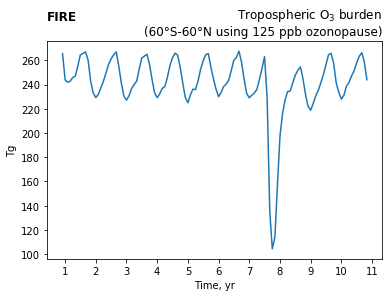

In [11]:
fig, ax = plt.subplots()
ax.plot(tstamps, o3_burden.data)
ax.set_title(f'{exp}\n', loc='left', weight='bold')
ax.set_xlabel('Time, yr')
ax.set_ylabel('Tg')
# Format xticklabels
plt.draw()
new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
ax.set_xticklabels(new_labels);
if trop_def == 'chemical' and S60N60:
    ax.set_title('Tropospheric $O_3$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_o3_burden_chemtrop_60S60N.png')
if trop_def == 'chemical' and not S60N60:
    ax.set_title('Tropospheric $O_3$ burden\n(using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_o3_burden_chemtrop.png')

#### Tropospheric CH4 burden

In [12]:
# Calculate CH4 burden per month
ch4_burden = (ch4*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
ch4_burden.convert_units('Tg')
# Calculate annual mean CH4 burden
ch4_burden_annual_mean = ch4_burden[t0:t1].data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(ch4_burden_annual_mean.data):1.2f}\u00B1{np.std(ch4_burden_annual_mean.data):1.2f} Tg')

3937.31±104.88 Tg


In [13]:
# ch4_burden_annual_mean_xojng = ch4_burden_annual_mean
# %store -r ch4_burden_annual_mean_xojnd

In [14]:
# p = stats.shapiro(ch4_burden_annual_mean_xojng - ch4_burden_annual_mean_xojnd)[1]
# print(p)
# if p > 0.05:
#     print(stats.ttest_rel(ch4_burden_annual_mean_xojng, ch4_burden_annual_mean_xojnd)[1])
# else: 
#     print(stats.wilcoxon(ch4_burden_annual_mean_xojng, ch4_burden_annual_mean_xojnd)[1])

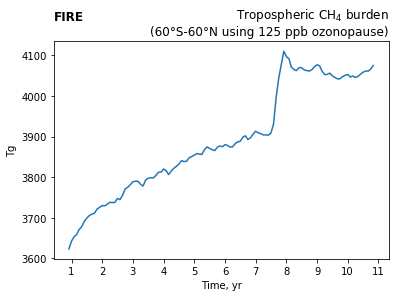

In [15]:
fig, ax = plt.subplots()
ax.plot(tstamps, ch4_burden.data)
ax.set_title(f'{exp}\n', loc='left', weight='bold')
ax.set_xlabel('Time, yr')
ax.set_ylabel('Tg')
# Format xticklabels
plt.draw() # force ticklabels to be generated
new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
ax.set_xticklabels(new_labels);
if trop_def == 'chemical' and S60N60:
    ax.set_title('Tropospheric $CH_4$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_ch4_burden_chemtrop_60S60N.png')
if trop_def == 'chemical' and not S60N60:
    ax.set_title('Tropospheric $CH_4$ burden\n(using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_ch4_burden_chemtrop.png')

#### CH4 lifetime

In [16]:
# Constants
k_ch4_oh = temp.copy(data=1.85e-12*np.exp(-1690/temp.data))
k_ch4_oh.rename('CH4+OH reaction rate coefficient')
k_ch4_oh.units='cm3 s-1'
molar_mass_oh = iris.coords.AuxCoord(17.007, units='g mol-1')
molar_mass_ch4 = iris.coords.AuxCoord(16.0425, units='g mol-1')
avogadro_number = iris.coords.AuxCoord(6.022*1e23, units='mol-1', long_name='avogadro_number')
# Find number of OH and CH4 molecules per grid box in the troposphere (tropospheric burden in molecules, not kg)
oh_molecules_per_gridbox = oh * air_mass * trop_mask / molar_mass_oh * avogadro_number
ch4_molecules_per_gridbox = ch4 * air_mass * trop_mask / molar_mass_ch4 * avogadro_number
## Prepare gridbox_vol cube for later multiplication by oh_molecules_per_gridbox cube
# Get rid of time coordinate
gridbox_vol = iris.util.squeeze(gridbox_vol) 
gridbox_vol.remove_coord('t')
# Copy oh_molecules_per_gridbox metadata to gridbox_vol cube
_var_name, _units = gridbox_vol.var_name, gridbox_vol.units
gridbox_vol = oh_molecules_per_gridbox[0, ...].copy(data=gridbox_vol.data)
gridbox_vol.rename(_var_name)
gridbox_vol.units = _units
gridbox_vol.remove_coord('forecast_reference_time')
# Calculate CH4 loss in molecules s-1
loss_ch4_oh = k_ch4_oh * ch4_molecules_per_gridbox * oh_molecules_per_gridbox / gridbox_vol
# Calculate CH4 lifetime
volume_sum = (['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
ch4_lifetime = ch4_molecules_per_gridbox.collapsed(*volume_sum) / loss_ch4_oh.collapsed(*volume_sum)
ch4_lifetime.convert_units('360 day')
# Calculate annual mean CH4 lifetime
ch4_lifetime_annual_mean = ch4_lifetime[t0:t1].data.reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(ch4_lifetime_annual_mean.data):1.3f}\u00B1{np.std(ch4_lifetime_annual_mean.data):1.3f} yr')

9.437±1.427 yr


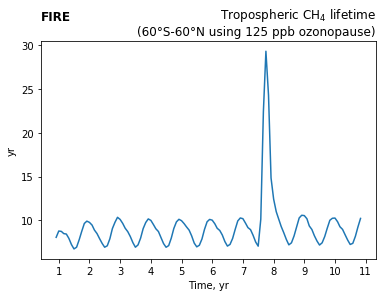

In [17]:
fig, ax = plt.subplots()
ax.plot(tstamps, ch4_lifetime.data)
ax.set_title(f'{exp}\n', loc='left', weight='bold')
ax.set_xlabel('Time, yr')
ax.set_ylabel('yr')
# Format xticklabels
plt.draw() # force ticklabels to be generated
new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
ax.set_xticklabels(new_labels);
if trop_def == 'chemical' and S60N60:
    ax.set_title('Tropospheric $CH_4$ lifetime\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_ch4_lifetime_chemtrop_60S60N.png');
if trop_def == 'chemical' and not S60N60:
    ax.set_title('Tropospheric $CH_4$ lifetime\n(using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_ch4_lifetime_chemtrop.png');

#### NH/SH air mass averaged tropospheric OH ratio

In [18]:
# Calculate OH in molecules per cm3
oh_molecules_per_cm3 = oh_molecules_per_gridbox/gridbox_vol
oh_molecules_per_cm3.convert_units('cm-3')
# Weight OH in each hemisphere by mass of air in each hemisphere
nh_constraint = iris.Constraint(latitude=lambda x: x>=0)
sh_constraint = iris.Constraint(latitude=lambda x: x<=0)
averaging_args = (['longitude', 'latitude', 'level_height'], iris.analysis.MEAN)
oh_nh = (oh_molecules_per_cm3*air_mass).extract(nh_constraint).collapsed(*averaging_args)/air_mass.extract(nh_constraint).collapsed(*averaging_args)
oh_sh = (oh_molecules_per_cm3*air_mass).extract(sh_constraint).collapsed(*averaging_args)/air_mass.extract(sh_constraint).collapsed(*averaging_args)
# Calculate annual mean OH ratio
oh_nh_annual_mean = oh_nh.data[t0:t1].reshape(n_yrs,12).mean(axis=1)
oh_sh_annual_mean = oh_sh.data[t0:t1].reshape(n_yrs,12).mean(axis=1)
print(f'{np.mean(oh_nh_annual_mean/oh_sh_annual_mean):1.3f}\u00B1{np.std(oh_nh_annual_mean/oh_sh_annual_mean):1.3f}')

1.378±0.032


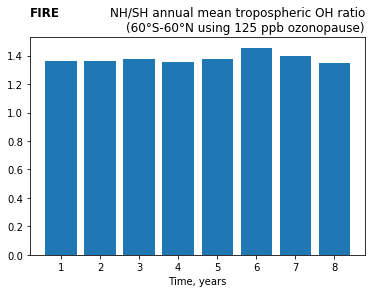

In [19]:
# Plot annual mean ratio of OH in the Northern Hemisphere to OH in the Southern Hemisphere
fig, ax = plt.subplots()
ax.bar(np.arange(1,n_yrs+1), oh_nh_annual_mean/oh_sh_annual_mean)
ax.set_title(f'{exp}\n', loc='left', weight='bold')
ax.set_xlabel('Time, years');
if trop_def == 'chemical' and S60N60:
    ax.set_title('NH/SH annual mean tropospheric OH ratio\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_oh_ratio_annual_mean_airmass_averaged_chemtrop_60S60N.png');
if trop_def == 'chemical' and not S60N60:
    ax.set_title('NH/SH annual mean tropospheric OH ratio\n(using 125 ppb ozonopause)', loc='right')
    fig.savefig(path_to_figs / f'{job}_oh_ratio_annual_mean_airmass_averaged_chemtrop.png');

#### Tropospheric RONO2 burdens

In [20]:
if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:
    # Calculate MeONO2 burden per month
    meono2_burden = (meono2*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
    meono2_burden.convert_units('Gg')
    # Calculate annual mean MeONO2 burden
    meono2_burden_annual_mean = meono2_burden[t0:t1].data.reshape(n_yrs,12).mean(axis=1)

    etono2_burden = (etono2*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
    etono2_burden.convert_units('Gg')
    etono2_burden_annual_mean = etono2_burden[t0:t1].data.reshape(n_yrs,12).mean(axis=1)

    nprono2_burden = (nprono2*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
    nprono2_burden.convert_units('Gg')
    nprono2_burden_annual_mean = nprono2_burden[t0:t1].data.reshape(n_yrs,12).mean(axis=1)

    iprono2_burden = (iprono2*air_mass*trop_mask).collapsed(['latitude', 'longitude', 'level_height'], iris.analysis.SUM)
    iprono2_burden.convert_units('Gg')
    iprono2_burden_annual_mean = iprono2_burden[t0:t1].data.reshape(n_yrs,12).mean(axis=1)

    print(f'MeONO2 {np.mean(meono2_burden_annual_mean.data):1.2f}\u00B1{np.std(meono2_burden_annual_mean.data):1.2f} Gg')
    print(f'EtONO2 {np.mean(etono2_burden_annual_mean.data):1.2f}\u00B1{np.std(etono2_burden_annual_mean.data):1.2f} Gg')
    print(f'nPrONO2 {np.mean(nprono2_burden_annual_mean.data):1.3f}\u00B1{np.std(nprono2_burden_annual_mean.data):1.3f} Gg')
    print(f'iPrONO2 {np.mean(iprono2_burden_annual_mean.data):1.3f}\u00B1{np.std(iprono2_burden_annual_mean.data):1.3f} Gg')

MeONO2 0.18±0.03 Gg
EtONO2 0.11±0.00 Gg
nPrONO2 0.004±0.000 Gg
iPrONO2 0.028±0.001 Gg


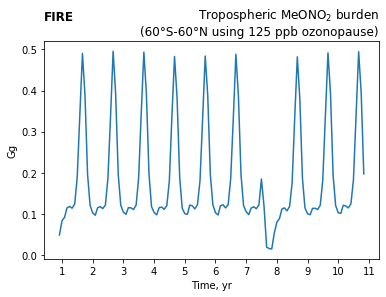

In [21]:
if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:
    fig, ax = plt.subplots()
    ax.plot(tstamps, meono2_burden.data)
    ax.set_title(f'{exp}\n', loc='left', weight='bold')
    ax.set_xlabel('Time, yr')
    ax.set_ylabel('Gg')
    plt.draw()
    new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
    ax.set_xticklabels(new_labels);
    if trop_def == 'chemical' and S60N60:
        ax.set_title('Tropospheric $MeONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_meono2_burden_chemtrop_60S60N.png')
    if trop_def == 'chemical' and not S60N60:
        ax.set_title('Tropospheric $MeONO_2$ burden\n(using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_meono2_burden_chemtrop.png')

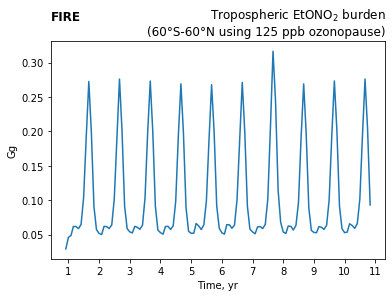

In [22]:
if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:     
    fig, ax = plt.subplots()
    ax.plot(tstamps, etono2_burden.data)
    ax.set_title(f'{exp}\n', loc='left', weight='bold')
    ax.set_xlabel('Time, yr')
    ax.set_ylabel('Gg')
    plt.draw()
    new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
    ax.set_xticklabels(new_labels);
    if trop_def == 'chemical' and S60N60:
        ax.set_title('Tropospheric $EtONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_etono2_burden_chemtrop_60S60N.png')
    if trop_def == 'chemical' and not S60N60:
        ax.set_title('Tropospheric $EtONO_2$ burden\n(using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_etono2_burden_chemtrop.png')

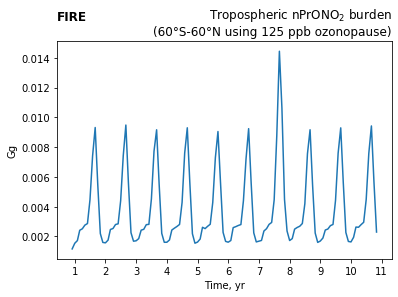

In [23]:
if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:   
    fig, ax = plt.subplots()
    ax.plot(tstamps, nprono2_burden.data)
    ax.set_title(f'{exp}\n', loc='left', weight='bold')
    ax.set_xlabel('Time, yr')
    ax.set_ylabel('Gg')
    plt.draw()
    new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
    ax.set_xticklabels(new_labels);
    if trop_def == 'chemical' and S60N60:
        ax.set_title('Tropospheric $nPrONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_nprono2_burden_chemtrop_60S60N.png')
    if trop_def == 'chemical' and not S60N60:
        ax.set_title('Tropospheric $nPrONO_2$ burden\n(using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_nprono2_burden_chemtrop.png')

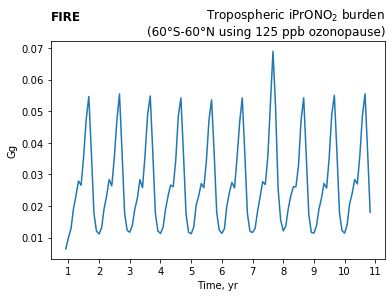

In [24]:
if exp in ['CHEM', 'MARI', 'FIRE', 'FULL']:     
    fig, ax = plt.subplots()
    ax.plot(tstamps, iprono2_burden.data)
    ax.set_title(f'{exp}\n', loc='left', weight='bold')
    ax.set_xlabel('Time, yr')
    ax.set_ylabel('Gg')
    plt.draw()
    new_labels = [int(i.get_text())-cb.coord('year').points[0] for i in ax.get_xticklabels(which='both')]
    ax.set_xticklabels(new_labels);
    if trop_def == 'chemical' and S60N60:
        ax.set_title('Tropospheric $iPrONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_iprono2_burden_chemtrop_60S60N.png')
    if trop_def == 'chemical' and not S60N60:
        ax.set_title('Tropospheric $iPrONO_2$ burden\n(using 125 ppb ozonopause)', loc='right')
        fig.savefig(path_to_figs / f'{job}_iprono2_burden_chemtrop.png')

In [25]:
break

SyntaxError: 'break' outside loop (<ipython-input-25-6aaf1f276005>, line 4)

#### Plot surface CH4

In [ ]:
import cartopy.util
import cartopy.crs as ccrs

In [ ]:
ch4_vmr = ch4*coeff_ch4
ch4_vmr_cyc, lons_cyc = cartopy.util.add_cyclic_point(ch4_vmr.data, coord=ch4_vmr.coord('longitude').points)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(lons_cyc, ch4_vmr.coord('latitude').points, ch4_vmr_cyc[12,0,...].data, 
                   vmin = ch4_vmr_cyc.min(), vmax = ch4_vmr_cyc.max(), transform=ccrs.PlateCarree())
ax.set_title('Surface $CH_4$, Dec')
ax.coastlines()
fig.colorbar(p0, shrink=0.4, label='');
fig.savefig('/local/mwe14avu/Desktop/new/ch4_surf_12.png', bbox_inches='tight')

In [ ]:
coeff_no2 = (28.97/46.006)*1e9
no2_vmr = no2*coeff_no2
no2_vmr_cyc, lons_cyc = cartopy.util.add_cyclic_point(no2_vmr.data, coord=no2_vmr.coord('longitude').points)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
p0 = ax.pcolormesh(lons_cyc, no2_vmr.coord('latitude').points, no2_vmr_cyc[0,0,...].data, transform=ccrs.PlateCarree()) #vmin = a_cyc.min(), vmax = a_cyc.max(),
ax.set_title('Surface something, Dec')
ax.coastlines()
fig.colorbar(p0, shrink=0.4, label='ppb');
fig.savefig('/local/mwe14avu/Desktop/current/smth_surf_dec.png', bbox_inches='tight')